In [1]:
import numpy as np
import pandas as pd
#mport cPickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='tensorflow'
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout, LSTM, GRU, Bidirectional
from keras.models import Model
from keras import backend as K
from keras.engine.topology import Layer, InputSpec




Using TensorFlow backend.


In [2]:
import pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [4]:
import pandas as pd

In [5]:
data_test=pd.read_csv("test_clean.csv")

In [6]:
data_test.shape

(153164, 3)

In [7]:
data=pd.read_csv("train_clean.csv")
#data=data[data.ENC_QUERY!='What can I ask?']
test=data

In [8]:
#data_train=pd.read_csv("kenesis_back_load.csv")[:50000]

In [11]:
test.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,22256635,Nonsense? kiss off geek what I said is true I'...,1,0,0,0,0,0
1,1,27450690,Please do not vandalize pages as you did with...,0,0,0,0,0,0
2,2,54037174,Points of interest I removed the points of in...,0,0,0,0,0,0
3,3,77493077,Asking some his nationality is a Racial offenc...,0,0,0,0,0,0
4,4,79357270,The reader here is not going by my say so for ...,0,0,0,0,0,0


In [13]:
def clean_str(string):
    """
    Tokenization/string cleaning for dataset

    Every dataset is lower cased except
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [22]:
texts = []
labels = []
for idx in range(data.shape[0]):
    text = BeautifulSoup(data.comment_text.iloc[idx])

    texts.append(clean_str(text.get_text()))

    labels.append(np.array(data[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]].iloc[idx]))

In [23]:
#labels=pd.Series(labels).values

In [24]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.05

In [25]:
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

/Users/nikhilkishore/anaconda/lib/python2.7/site-packages/keras/preprocessing/text.py:145: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


In [26]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 151434 unique tokens.


In [27]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [31]:
texts[0]

u'nonsense? kiss off geek what i said is true ill have your account terminated'

In [39]:
labels=np.array(labels)

In [40]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

('Shape of data tensor:', (95851, 1000))
('Shape of label tensor:', (95851, 6))


In [41]:
data.shape

(95851, 1000)

In [42]:
labels

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ..., 
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [43]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

In [44]:
x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

In [45]:
print('Traing and validation set number of positive and negative reviews')
print (y_train.sum(axis=0))
print (y_val.sum(axis=0))

Traing and validation set number of positive and negative reviews
[8786  914 4870  292 4532  772]
[451  51 239  13 233  42]


In [46]:
GLOVE_DIR = "/Users/nikhilkishore/Google Drive/personal Efforts/NLP/glove"
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [47]:
print('Total %s word vectors.' % len(embeddings_index))

Total 400000 word vectors.


In [48]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [49]:
embedding_matrix.shape

(151435, 100)

In [57]:
from keras.models import load_model
model=load_model('NLP_insult.h5')

In [50]:
import tensorflow as tf

In [58]:
#BiRNN > LSTM
from keras import regularizers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten,Add, Conv1D, Concatenate
from keras.layers import AveragePooling2D, MaxPooling1D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Reshape
from keras.layers import GRU

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)


sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
print embedded_sequences.shape
l_lstm = Bidirectional(LSTM(120,kernel_regularizer=regularizers.l2(0.001)))(embedded_sequences)
print l_lstm.shape
preds = Dense(6, activation='softmax')(l_lstm)
model3 = Model(sequence_input, preds)
print sequence_input.shape,preds.shape
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc'])
print("model fitting - Bidirectional LSTM")
model3.summary()
model3.fit(x_train, y_train, validation_data=(x_val, y_val) ,epochs=5, batch_size=128)

(?, 1000, 100)
(?, 240)
(?, 1000) (?, 6)
model fitting - Bidirectional LSTM
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 1000, 100)         15143500  
_________________________________________________________________
bidirectional_3 (Bidirection (None, 240)               212160    
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 1446      
Total params: 15,357,106
Trainable params: 15,357,106
Non-trainable params: 0
_________________________________________________________________
Train on 91059 samples, validate on 4792 samples
Epoch 1/5
91059/91059 [==============================] - 5857s - loss: 0.2363 - acc: 0.9631 - val_loss: 0.2247 - val_acc: 0.9642
Epoch 2/

In [59]:
model.get_weights()[0]

array([[ 0.88576508,  0.04944112,  0.19536407, ...,  0.81031239,
         0.72478044,  0.53271431],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
         0.47646999, -0.15983   ],
       ..., 
       [ 0.0657315 ,  0.91747099,  0.45689389, ...,  0.47231841,
         0.98781145,  0.72044647],
       [ 0.71692008,  0.36381185,  0.82032627, ...,  0.17624725,
         0.12551785,  0.07725205],
       [ 0.56348997,  0.34685999, -0.43801999, ..., -0.32756999,
         0.48758   , -0.87645   ]], dtype=float32)

In [60]:
model.get_weights()[0]

array([[ 0.88576508,  0.04944112,  0.19536407, ...,  0.81031239,
         0.72478044,  0.53271431],
       [-0.038194  , -0.24487001,  0.72812003, ..., -0.1459    ,
         0.82779998,  0.27061999],
       [-0.18970001,  0.050024  ,  0.19084001, ..., -0.39804   ,
         0.47646999, -0.15983   ],
       ..., 
       [ 0.0657315 ,  0.91747099,  0.45689389, ...,  0.47231841,
         0.98781145,  0.72044647],
       [ 0.71692008,  0.36381185,  0.82032627, ...,  0.17624725,
         0.12551785,  0.07725205],
       [ 0.56348997,  0.34685999, -0.43801999, ..., -0.32756999,
         0.48758   , -0.87645   ]], dtype=float32)

In [115]:
from keras.models import load_model

model.save('NLP.h5')

In [62]:
history=model3.history

In [63]:
(history.history['val_acc'])

[0.96421119396595012,
 0.96414163773366324,
 0.96584586169763476,
 0.96459377608036556,
 0.96483724055584763]

['acc', 'loss', 'val_acc', 'val_loss']


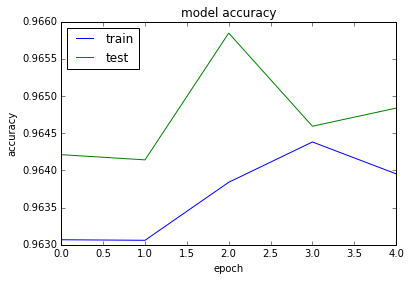

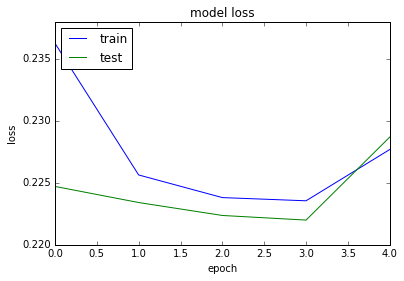

In [64]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [67]:
def textparser(query): 
    t2=[]
    t1 = BeautifulSoup(query)
    t2.append(clean_str(t1.get_text()))
    return t2

def predict_individually(q):
    st= textparser(q)

    #tokenizer.fit_on_texts(st)
    sequences_label = tokenizer.texts_to_sequences(st)
    test_data_temp = pad_sequences(sequences_label, maxlen=MAX_SEQUENCE_LENGTH)
    return test_data_temp

In [113]:
def textparser(query): 
    t2=[]
    t1 = BeautifulSoup(query)
    t2.append(clean_str(t1.get_text()))
    return t2

st= textparser("i hate you")

#tokenizer.fit_on_texts(st)
sequences_label = tokenizer.texts_to_sequences(st)
test_data = pad_sequences(sequences_label, maxlen=MAX_SEQUENCE_LENGTH)

In [114]:
l=list(map(lambda x,y: (x,y),test.columns[3:],model3.predict(test_data)[0]))
sorted(l,key=lambda x:x[1],reverse=True)

[('toxic', 0.52141786),
 ('insult', 0.21128668),
 ('obscene', 0.17838337),
 ('identity_hate', 0.041068539),
 ('severe_toxic', 0.031064529),
 ('threat', 0.01677903)]